# TMA Analysis code supporting SITCOM-1310
Craig Lage - 07-Apr-24

During several nights, the TMA was set to track for long period, form 10 minutes to over an hour.  Then the StarTrackers were used to determine how well the TMA was tracking the sky.  This long term drift could be due to TMA deficiencies, or to deficiencies in the pointing model.

# Prepare the notebook

In [1]:
# Directory to store the data
from pathlib import Path
dataDir = Path("./plots")
dataDir.mkdir(exist_ok=True, parents=True)

# These are the nights when the tests were run
dayObss = [20240403, 20240404, 20240405]
#dayObss = [20240418]

# Some sequences give NaNs for some reason.  Skipping those.
# This is the dayObs, and the first seqNum of the exposure series.
# These seem to be ones at the beginning or end of the night
onesToSkip = [[20240403, 98], [20240404, 15], [20240404, 17], [20240404, 1042]]

# Note that the fast camera code requires using the 
# tickets/DM-43774 branch of summit_extras.

In [2]:
import sys, time, os, asyncio, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.time import Time, TimeDelta
from lsst.summit.utils.utils import dayObsIntToString
from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, getAzimuthElevationDataForEvent, filterBadValues

from lsst.summit.extras.fastStarTrackerAnalysis import getRegularSequences
from lsst.summit.extras.fastStarTrackerAnalysis import findFastStarTrackerImageSources

%matplotlib inline

In [3]:
client = EfdClient("usdf_efd")
eventMaker = TMAEventMaker()

In [4]:
def findMatchingImages(event, jsonData, camera):
    # This finds StarTracker images that were
    # taken during a long slew by matching RA and Dec
    prePad = 30.0
    postPad = 30.0
    begin = track.begin.value 
    end = track.end.value
    midTime = (begin + end) / 2.0
    for i in range(len(jsonData)):
        # Find the exposure closest to the midpoint
        if np.isnan(jsonData.iloc[i][f'MJD {camera}']) or np.isnan(jsonData.iloc[i][f'Ra {camera}']):
            continue
        thisTime = Time(jsonData.iloc[i][f'MJD {camera}'], format='mjd').unix_tai - 37.0
        if abs(thisTime - midTime) < 30.0:
            break
    ra = jsonData.iloc[i][f'Ra {camera}']
    dec = jsonData.iloc[i][f'Dec {camera}']
    seqNums = []
    for i in range(len(jsonData)):
        if np.isnan(jsonData.iloc[i][f'Ra {camera}']):
            continue
        thisTime = Time(jsonData.iloc[i][f'MJD {camera}'], format='mjd').unix_tai - 37.0
        if (thisTime > begin - prePad) and (thisTime < end + postPad):
            dra = abs(ra - jsonData.iloc[i][f'Ra {camera}'])
            ddec = abs(dec - jsonData.iloc[i][f'Dec {camera}'])
            #print(i, dra, ddec)
            if (dra < 0.1) and (ddec < 0.1):
                seqNums.append(jsonData.index[i])
    return seqNums


### This uses the json metadata from RubinTV, which contains the astrometric solutions for the StarTracker exposures.  You need to download the metadata for each dayObs and put it in a location where the program can find it.

In [5]:
# This disables the annoying logging associated with filterBadValues
import logging.config
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
})

In [6]:
fastPlateScale = 0.67 # arcsec/pixel
pdf = PdfPages(dataDir / f"Long_Term_Tracking_Events_{dayObss[0]}_{dayObss[-1]}.pdf")
fig = plt.figure(figsize=(15,10))

# The lists below will be used to plot the 
# tracking drift vs AltAz
alts = []
azs = []
raDrifts = []
decDrifts = []

for dayObs in dayObss:
    dayObsString = dayObsIntToString(dayObs)
    filename = f'../json_metadata/startracker_narrow_{dayObsString}.json'
    jsonData = pd.read_json(filename).T
    jsonData = jsonData.sort_index()
    events = eventMaker.getEvents(dayObs)
    longTracks = [e for e in events if (e.type.name == 'TRACKING' and e.duration > 500)]
    files = getRegularSequences(dayObs) # This is for the fast camera data

    for n, track in enumerate(longTracks):
        seqNums = []
        seqNums = findMatchingImages(track, jsonData, 'narrow')
        print(f"For long track beginning at {track.begin.isot},there are {len(seqNums)} narrow images that match")
        if len(seqNums) == 0:
            continue
        # This is for the encoder data        
        azimuthData, elevationData = getAzimuthElevationDataForEvent(client, track)
        azTimes = azimuthData['timestamp'].values
        azTimes -= azTimes[0]
        azErrors = azimuthData['azError'].values
        filterBadValues(azErrors, maxConsecutiveValues=10)
        elTimes = elevationData['timestamp'].values
        elTimes -= elTimes[0]
        elErrors = elevationData['elError'].values
        filterBadValues(elErrors, maxConsecutiveValues=10)

        # Now this is for the narrow data
        times = []
        ras = []
        decs = []
        for seqNum in seqNums:
            try:
                time = Time(jsonData[jsonData.index == seqNum]['MJD narrow'].values[0], format='mjd').unix_tai
                ra = jsonData[jsonData.index == seqNum]['Calculated Ra narrow'].values[0]
                dec = jsonData[jsonData.index == seqNum]['Calculated Dec narrow'].values[0]
                ras.append(ra)
                decs.append(dec)
                times.append(time)
            except:
                continue

        if [dayObs, seqNums[0]] in onesToSkip:
            continue
        azs.append(np.median(azimuthData['actualPosition'].values))
        alts.append(np.median(elevationData['actualPosition'].values))
        
        times = np.array(times)
        times -= times[0]
        ras = np.array(ras)
        ras = (ras - ras[0]) * 3600.0
        decs = np.array(decs)
        decs = (decs - decs[0]) * 3600.0
        raDrift = (ras[-1] - ras[0]) / times[-1] * 30.0
        decDrift = (decs[-1] - decs[0]) / times[-1] * 30.0
        if np.isnan(raDrift) or np.isnan(decDrift):
            continue
        raDrifts.append(raDrift)
        decDrifts.append(decDrift)
        axs = fig.subplots(2,3)
        plt.suptitle(f"Long term tracking drift {dayObsString}: {seqNums[0]} - {seqNums[-1]}  RA = {ra:.2f}, Dec = {dec:.2f}", \
                     fontsize=18)
        plt.subplots_adjust(wspace=0.3)
        axs[0][0].set_title(f"Narrow RA drift = {raDrift:.2f} arcseconds/30 seconds")
        axs[0][0].scatter(times, ras)
        axs[0][0].set_ylabel("RA Drift (arcseconds)")
        axs[0][0].set_xlabel("Time (seconds)")
        axs[0][1].set_title(f"Narrow Dec drift = {decDrift:.2f} arcseconds/30 seconds")
        axs[0][1].scatter(times, decs)
        axs[0][1].set_ylabel("Dec Drift (arcseconds)")
        axs[0][1].set_xlabel("Time (seconds)")
        axs[0][2].set_title("Encoder tracking errors")
        axs[0][2].plot(azTimes, azErrors, color='green', label='Az')
        axs[0][2].plot(elTimes, elErrors, color='red', label='El')
        axs[0][2].set_ylabel("Errors (arcsec)")
        axs[0][2].set_xlabel("Time (sec)")
        axs[0][2].set_ylim(-1.0,1.0)
        axs[0][2].legend()

        # Now for the fast data
        seqNums = findMatchingImages(track, jsonData, 'fast')
        print(f"For long track beginning at {track.begin.isot},there are {len(seqNums)} fast images that match")
        if len(seqNums) == 0:
            continue
        cenXs = []
        cenYs = []
        fastTimes = []

        for seqNum in seqNums:
            try:
                filename = [b for (a,b) in files if a == seqNum][0]
                result = findFastStarTrackerImageSources(filename, boxSize=50, streaming=False)
                fastTime = Time(jsonData[jsonData.index == seqNum]['MJD fast'].values[0], format='mjd').unix_tai
                cenXs.append(result[0].centroidX)
                cenYs.append(result[0].centroidY)
                fastTimes.append(fastTime)
            except:
                continue
        
        if len(cenXs) == 0:
            print("Fast images failed to solve")
            axs[1][0].set_title("No valid fast data")
            axs[1][1].set_title("No valid fast data")
            axs[1][2].axis('off')
        else:
            fastTimes = np.array(fastTimes)
            fastTimes -= fastTimes[0]
            cenXs = np.array(cenXs) * fastPlateScale
            cenYs = np.array(cenYs) * fastPlateScale
            xFit = np.polyfit(fastTimes, cenXs, 1)
            yFit = np.polyfit(fastTimes, cenYs, 1)
            xPlot = np.linspace(fastTimes[0], fastTimes[-1], 100)
            yPlotXcen = np.polyval(xFit, xPlot)
            yPlotYcen = np.polyval(yFit, xPlot)
            xDrift = (yPlotXcen[-1] - yPlotXcen[0]) / (xPlot[-1] - xPlot[0]) * 30.0
            yDrift = (yPlotYcen[-1] - yPlotYcen[0]) / (xPlot[-1] - xPlot[0]) * 30.0
            axs[1][0].set_title(f"Fast X drift = {xDrift:.2f} arcseconds/30 seconds")
            axs[1][0].scatter(fastTimes, cenXs)
            axs[1][0].plot(xPlot, yPlotXcen, color='red', ls = '--')
            axs[1][0].set_ylabel("X Drift (arcseconds)")
            axs[1][0].set_xlabel("Time (seconds)")
            axs[1][1].set_title(f"Fast Y drift = {yDrift:.2f} arcseconds/30 seconds")
            axs[1][1].scatter(fastTimes, cenYs)
            axs[1][1].plot(xPlot, yPlotYcen, color='red', ls = '--')
            axs[1][1].set_ylabel("Y Drift (arcseconds)")
            axs[1][1].set_xlabel("Time (seconds)")
            axs[1][2].axis('off')
        pdf.savefig(fig)  # saves the current figure into a pdf page
        plt.clf()
pdf.close()


Found 749 regular files on dayObs 20240403
For long track beginning at 2024-04-04T01:11:55.845,there are 0 narrow images that match
For long track beginning at 2024-04-04T02:12:10.155,there are 0 narrow images that match
For long track beginning at 2024-04-04T03:59:31.492,there are 80 narrow images that match
For long track beginning at 2024-04-04T03:59:31.492,there are 80 fast images that match
For long track beginning at 2024-04-04T04:16:12.398,there are 80 narrow images that match
For long track beginning at 2024-04-04T04:32:19.620,there are 80 narrow images that match
For long track beginning at 2024-04-04T04:32:19.620,there are 80 fast images that match
For long track beginning at 2024-04-04T04:49:38.102,there are 80 narrow images that match
For long track beginning at 2024-04-04T04:49:38.102,there are 80 fast images that match
For long track beginning at 2024-04-04T05:25:14.448,there are 80 narrow images that match
For long track beginning at 2024-04-04T05:25:14.448,there are 80 

<Figure size 1500x1000 with 0 Axes>

# This cell plots the drift errors vs AltAz, using the size of the plot marker to indicate the tracking drift.
# This only applies to the narrow camera.

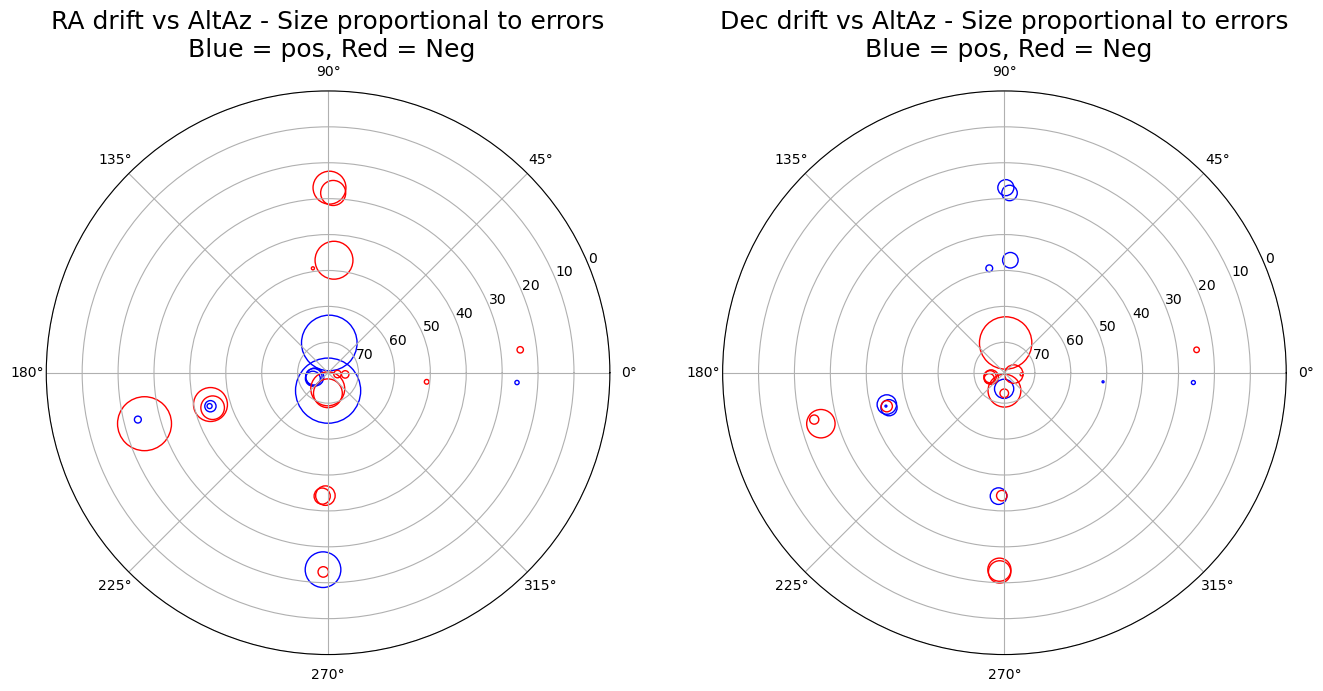

In [7]:
radAzs = np.radians(azs)
fig=plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, projection='polar')
ax1.invert_yaxis()
ax1.set_title("RA drift vs AltAz - Size proportional to errors\n Blue = pos, Red = Neg", fontsize=18)
radAzsPos = []
radAzsNeg = []
altsPos = []
altsNeg = []
raDriftsPos = []
raDriftsNeg = []
for n, raDrift in enumerate(raDrifts):
    if raDrift > 0.0:
        radAzsPos.append(radAzs[n])
        altsPos.append(alts[n])
        raDriftsPos.append(raDrift)
    else:
        radAzsNeg.append(radAzs[n])
        altsNeg.append(alts[n])
        raDriftsNeg.append(raDrift)
raSizePos = abs(np.array(raDriftsPos)) * 500.0
raSizeNeg = abs(np.array(raDriftsNeg)) * 500.0

ax1.scatter(radAzsPos, altsPos, color='blue', marker='o', s=raSizePos, facecolors='none' )
ax1.scatter(radAzsNeg, altsNeg, color='red', marker='o', s=raSizeNeg, facecolors='none' )

ax2 = plt.subplot(122, projection='polar')
ax2.invert_yaxis()
ax2.set_title("Dec drift vs AltAz - Size proportional to errors\n Blue = pos, Red = Neg", fontsize=18)
radAzsPos = []
radAzsNeg = []
altsPos = []
altsNeg = []
decDriftsPos = []
decDriftsNeg = []
for n, decDrift in enumerate(decDrifts):
    if decDrift > 0.0:
        radAzsPos.append(radAzs[n])
        altsPos.append(alts[n])
        decDriftsPos.append(decDrift)
    else:
        radAzsNeg.append(radAzs[n])
        altsNeg.append(alts[n])
        decDriftsNeg.append(decDrift)
decSizePos = abs(np.array(decDriftsPos)) * 500.0
decSizeNeg = abs(np.array(decDriftsNeg)) * 500.0
ax2.scatter(radAzsPos, altsPos, color='blue', marker='o', s=decSizePos, facecolors='none' )
ax2.scatter(radAzsNeg, altsNeg, color='red', marker='o', s=decSizeNeg, facecolors='none' )
plt.savefig(dataDir / "Long_Term_Tracking_Drifts_AltAz_29Apr24.pdf")